In [1]:
from shapely.geometry import MultiPolygon, Polygon

import pandas as pd
import geopandas as gpd
import numpy as np

import datetime

from matplotlib import pyplot as plt

import requests
import arrow

import sys
sys.path.append('/home/jovyan/python-helper/src/')

from loggers import TimeEstimator

from matplotlib.colors import LinearSegmentedColormap

In [3]:
def interpolate_perimeter(vertices, dnumber):
    if len(vertices) == dnumber:
        return vertices
    
    vertices = np.array(vertices)
    step_len = np.sqrt(np.sum(np.diff(vertices, 1, 0)**2, 1)) # length of each side
    step_len = np.append([0], step_len)
    cumulative_len = np.cumsum(step_len)
    interpolation_loc = np.linspace(0, cumulative_len[-1], dnumber)
    X = np.interp(interpolation_loc, cumulative_len, vertices[:,0])
    Y = np.interp(interpolation_loc, cumulative_len, vertices[:,1])

    return list(zip(X,Y))

def find_pairs(vertices_A, vertices_B):
    # Returns a list of quadruples: (AX, AY, BX, BY)
    
    number_of_vertices = max(len(vertices_A), len(vertices_B))
    
    vertices_A = interpolate_perimeter(vertices_A, number_of_vertices)
    vertices_B = interpolate_perimeter(vertices_B, number_of_vertices)
    
    # Find closest points to start with
    distance_to_zero = []
    for vertex_B in vertices_B:
        distance = np.sqrt((vertices_A[0][0] - vertex_B[0])**2 + 
                           (vertices_A[0][1] - vertex_B[1])**2)
        
        distance_to_zero.append(distance)
        
    minidx = np.argmin(distance_to_zero)
    
    return_list = []
    for i, vertex_A in enumerate(vertices_A):
        B_i = (i + minidx)%len(vertices_B)
        vertex_B = vertices_B[B_i]
        
        return_list.append((vertex_A[0], vertex_A[1], vertex_B[0], vertex_B[1]))
        
    return return_list

def collect_wx_data(centroid, fromdt, todt):
    km_per_miles = 1.60934
    
    baseURL = "https://firemap.sdsc.edu/pylaski/stations/data?"

    ## Always start with the base of the URL

    selectionType='selection=withinRadius'

    # Choose the centroid of the ignition
    lon = centroid.x
    lat = centroid.y
    radius = 2*km_per_miles    # 2 mile radius

    ## Latitude and longitude of the White House according to Google
    selectionParameters = '&lat={}&lon={}&radius={}'.format(str(lat),str(lon), str(radius))

    observables_list = ['temperature', 'wind_speed', 'wind_direction']
    observables = ''
    for observable in observables_list:
        observables += f'&observable={observable}'

#     fromdt = ignite['datetime'].tz_localize('US/Pacific')
#     todt = compare['datetime'].tz_localize('US/Pacific')
    frm = arrow.Arrow.fromdatetime(fromdt.to_pydatetime())
    to = arrow.Arrow.fromdatetime(todt.to_pydatetime())

    frm = frm.shift(minutes=-10)
    to = to.shift(minutes=10)

    urlDateTime = '&from={}&to={}'.format(str(frm), str(to))

    urlPlot = baseURL + selectionType + selectionParameters + observables + urlDateTime
    print(urlPlot)

    r = requests.get(urlPlot)
    ## Request to GET information from the given URL (Our REST query we built)
    return r.json()

def calculate_indices(x, edge_value, bin_counts):
    xix = ((x + edge_value)/(2*edge_value/bin_counts)).astype(int)
    xix[xix>=bin_counts] = bin_counts-1
    xix[xix<0] = 0
    
    return xix

def calculate_binned_winds(x, y, weights, edge_value, bin_counts):
    xix = calculate_indices(x, edge_value, bin_counts)
    yix = calculate_indices(y, edge_value, bin_counts)

    XY = np.zeros((bin_counts, bin_counts))
    for i,j, weight in zip(xix, yix, weights):
        XY[i,j] += weight

    return XY


# def convolve_timeseries(times, values, hours=6):
#     if np.unique(np.diff(times)).size > 1:
#         print('Variable time interval is given! This is not yet implemented!')

#     # Calculate the kernel size from the fixed time difference
#     dt = times[1]-times[0]
#     kernel_size = int(hours*3600/dt.total_seconds())
#     if kernel_size%2 == 0:  # Make kernel size an odd number
#         kernel_size += 1
        
    
#     # Calculate the convolution:
#     convolved_values = np.convolve(values, np.ones(kernel_size), mode='valid')/kernel_size
#     clip_index = int((kernel_size-1)/2)
#     time_clipped = times[clip_index:-clip_index]
    
    
#     return time_clipped, convolved_values, clip_index

In [4]:
def change_username_to_jovyan(df, column):

    for ix, row in df.iterrows():
        path_list = row['filepath'].split('/')
        path_list[2] = 'jovyan'

        path = ''
        for string in path_list[:-1]:
            path += f'{string}/'
        path += path_list[-1]

        df.loc[ix, column] = path

In [5]:
gdfMariaSim = pd.read_pickle('~/farsite-devAPI/src/Maria2019_simulation.pkl')
change_username_to_jovyan(gdfMariaSim, 'filepath')
change_username_to_jovyan(gdfMariaSim, 'configpath')

df = pd.read_pickle('~/data/test_table.pkl')
dfMaria = df[(df['description'] == 'Maria2019') & 
             (df['filetype'] == 'Ignition')]
change_username_to_jovyan(dfMaria, 'filepath')

for ix, row in dfMaria.iterrows():
    if isinstance(gpd.read_file(row['filepath'])['geometry'].iloc[0], MultiPolygon):
        dfMaria.loc[ix, 'geometry'] = gpd.read_file(row['filepath'])['geometry'].iloc[0].geoms[0]
    elif isinstance(gpd.read_file(row['filepath'])['geometry'].iloc[0], Polygon):
        dfMaria.loc[ix, 'geometry'] = gpd.read_file(row['filepath'])['geometry'].iloc[0]
    else:
        print('type is not Polygon or MultiPolygon. Check!!')
        break
gdfMariaIgnition = gpd.GeoDataFrame(dfMaria, crs='EPSG:5070', geometry='geometry')

/tmp/ipykernel_113/2238128631.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.loc[ix, column] = path
/tmp/ipykernel_113/885252770.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfMaria.loc[ix, 'geometry'] = gpd.read_file(row['filepath'])['geometry'].iloc[0]


In [6]:
%%time

compareidx = '911f9b001c054b74a6ba70958f5f3c93'

vertices_observed = list(gdfMariaIgnition.loc[compareidx]['geometry'].exterior.coords)
centroid = gdfMariaIgnition.to_crs(epsg=4326).loc[compareidx, 'geometry'].centroid

fromdate = gdfMariaIgnition.loc[compareidx, 'datetime'].tz_localize('US/Pacific') - datetime.timedelta(hours=6)
todate = gdfMariaIgnition.loc[compareidx, 'datetime'].tz_localize('US/Pacific')
wxdata = collect_wx_data(centroid, fromdate, todate)

https://firemap.sdsc.edu/pylaski/stations/data?selection=withinRadius&lat=34.309745002942876&lon=-119.04971165334099&radius=3.21868&observable=temperature&observable=wind_speed&observable=wind_direction&from=2019-10-31T14:46:44-07:00&to=2019-10-31T21:06:44-07:00
CPU times: user 52.3 ms, sys: 7.96 ms, total: 60.3 ms
Wall time: 1.07 s


In [7]:
for feature in wxdata['features']:
    name = feature['properties']['description']['name']
    wifireuid = feature['properties']['description']['wifire_uid']
    
    
    distance = feature['properties']['distanceFromLocation']
    coordinates = feature['geometry']['coordinates']
    
    times = pd.to_datetime(feature['properties']['timestamp'])
    
    units = feature['properties']['units']
    temperatures = feature['properties']['temperature']
    windspeeds = feature['properties']['wind_speed']
    winddirections = feature['properties']['wind_direction']
    
    print(f'name: {name}\ndist: {distance}')
    

name: SCE Hondo Barranca Rd
dist: {'value': 1.3020255515633772, 'units': 'km'}


In [8]:
df = pd.DataFrame(index=times, data={'temperature': temperatures, 'windspeed': windspeeds, 'winddirection': winddirections})
df['U'] = df['windspeed']*np.cos(df['winddirection']/180*np.pi)
df['V'] = df['windspeed']*np.sin(df['winddirection']/180*np.pi)
df['hour'] = df.index.hour
df = df.sort_index()

In [14]:
x = df.dropna()['U'].values
y = df.dropna()['V'].values
t = df.dropna().index

alpha_range = np.arange(1, len(x)+1)/len(x)
colors = []
for alpha in alpha_range:
    colors.append((0,0,1,alpha))
cmap = LinearSegmentedColormap.from_list('WhiteBlue', colors=[(1,1,1,1), (0,0,1,1)])

    
tdiff_seconds = (t - t[0]).total_seconds()
weights = tdiff_seconds/tdiff_seconds.max()
    
# plot_binned_winds(x, y, weights, 15, 51, df.iloc[-1].index.name)
XY = calculate_binned_winds(x, y, weights, 15, 51)
ixmax, jxmax = np.unravel_index(XY.argmax(), XY.shape)
(x[ixmax], y[jxmax])

IndexError: index 39 is out of bounds for axis 0 with size 38

In [16]:
x

array([ 2.65374293e+00,  1.67075543e+00,  2.82884385e+00,  1.44725657e+00,
        5.96069640e-01,  2.23671969e+00,  2.53672916e+00,  1.81541892e+00,
        9.17564876e-01,  2.30627433e+00,  1.87045740e+00,  1.59688455e+00,
        1.70982374e+00,  1.44937563e+00,  1.70555169e+00,  5.34323752e-01,
       -1.79901890e-01, -2.73395258e-01,  6.57456028e-01,  9.17662125e-02,
        3.36352593e-01,  1.91584099e-01,  1.82427766e-01,  6.35236632e-03,
        7.16314110e-01, -2.46436958e-01,  1.56062541e-01, -6.84720431e-01,
        1.87581875e+00,  3.31254300e+00,  4.40402759e+00,  4.90621480e+00,
        2.71627092e+00,  4.83975003e+00,  1.01117894e+01,  8.01455626e+00,
        8.40847407e+00,  7.59323742e+00])

Calculating for ws=10.0, wd=90.0


/tmp/ipykernel_49/361801782.py:12: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  vertices_simulated = list(gdfMariaSim[(gdfMariaSim['windspeed'] == windspeed) &


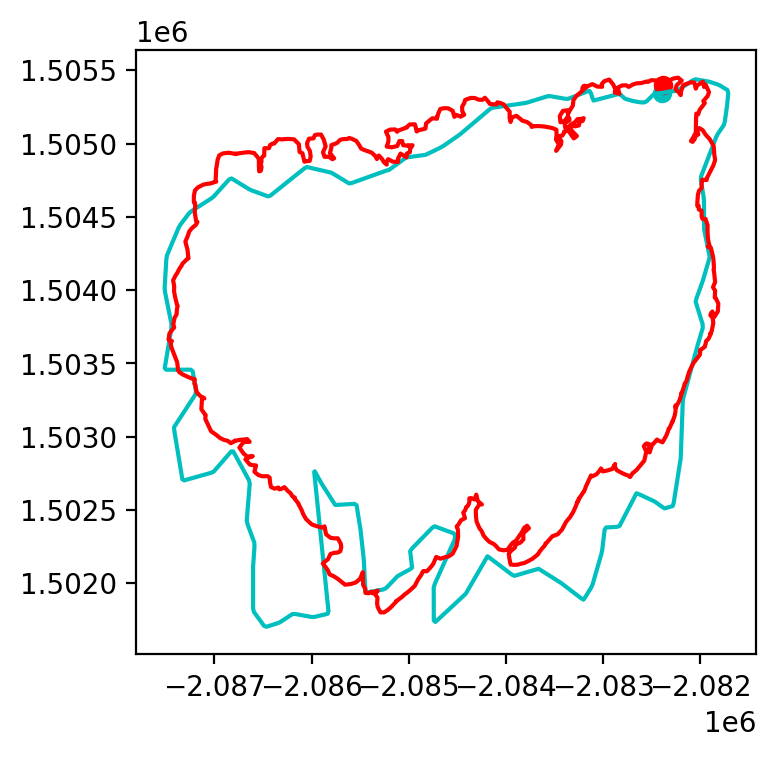

In [15]:
windspeeds = gdfMariaSim['windspeed'].unique()
winddirections = gdfMariaSim['winddirection'].unique()

wsidx = 10
wdidx = 15

windspeed = windspeeds[wsidx]
winddirection = winddirections[wdidx]

print(f'Calculating for ws={windspeed}, wd={winddirection}')

vertices_simulated = list(gdfMariaSim[(gdfMariaSim['windspeed'] == windspeed) &
                                      (gdfMariaSim['winddirection'] == winddirection) &
                                      (gdfMariaSim['compareidx'] == compareidx)].iloc[0]['geometry'][0].exterior.coords)
vertex_pairs = find_pairs(vertices_observed, vertices_simulated)
vertex_pairs_np = np.array(vertex_pairs)

vertices_A = vertex_pairs_np[:, :2]
vertices_B = vertex_pairs_np[:, 2:]

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

ax.plot(vertices_A[0,0], vertices_A[0,1], 'co')
ax.plot(vertices_B[0,0], vertices_B[0,1], 'ro')

ax.plot(vertices_A[:,0], vertices_A[:,1], 'c')
ax.plot(vertices_B[:,0], vertices_B[:,1], 'r')

In [21]:
def plot_wind_values(x, y, alpha_range, colors, title):
    # Returns fig, ax

    fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
    ax.set_aspect('equal')
    plt.subplots_adjust(left=0.2)
    ax.scatter(x, y, color=colors, edgecolors='none')

    ax.set_xlim(-15,15)
    ax.set_ylim(-15,15)
    ax.set_xlabel('East-West Winds (mph)')
    ax.set_ylabel('North-South Winds (mph)')
    ax.set_title(title)
    
    return fig, ax

## Creating animations

In [31]:
number_of_steps = 500
first_ix = 3000
final_ix = len(df)
startix = first_ix
endix = startix + number_of_steps

number_of_frames = final_ix - first_ix-number_of_steps-1
time_estimator = TimeEstimator(number_of_frames)
for i in range(number_of_frames):
    i += first_ix
    if i%10 == 0:
        print(time_estimator.info_str(i-first_ix), end='\r', flush=True)
        
    x = df.dropna().iloc[startix:endix]['U'].values
    y = df.dropna().iloc[startix:endix]['V'].values
    t = df.dropna().iloc[startix:endix].index.values.astype(np.int64)/1e9
    
    alpha_range = np.arange(1, len(x)+1)/len(x)
    colors = []
    for alpha in alpha_range:
        colors.append((0,0,1,alpha))
    
    fig, ax = plot_wind_values(x, y, alpha_range, colors,
                             title = f'time: {df.iloc[endix].name}')

    startix += 1
    endix += 1
    
    fig.savefig(f'scatter_movie/scatter_plot_{number_of_steps}_{i}.png')
    plt.close(fig)

In [15]:
! ffmpeg -f image2 -r 20 -i scatter_movie/scatter_plot_500_%d.png -c:v libx264 -pix_fmt yuv420p scatter_500.mp4

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

In [ ]:
! scp scatter_500.mp4 hotshot:/home/tcaglar/

In [27]:

def plot_binned_winds(x, y, weights, edge_value, bin_counts, title):
    XY = calculate_binned_winds(x, y, weights, edge_value, bin_counts)

    cmap = LinearSegmentedColormap.from_list('WhiteBlue', colors=[(1,1,1,1), (0,0,1,1)])
    
    
    fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
    ax.imshow(XY.T, extent=[-edge_value,edge_value,-edge_value,edge_value],
               origin='lower', cmap = cmap, aspect='equal')
        
    ax.set_xlabel('East-West Winds (mph)')
    ax.set_ylabel('North-South Winds (mph)')
    ax.set_title(title)
    
    return fig, ax


In [10]:
number_of_steps = 500
first_ix = len(df)-1000
final_ix = len(df)
startix = first_ix
edge_value = 15
bin_counts = 51

endix = startix + number_of_steps

alpha_range = np.arange(1, number_of_steps+1)/number_of_steps

cmap = LinearSegmentedColormap.from_list('WhiteBlue', colors=[(1,1,1,1), (0,0,1,1)])

number_of_frames = final_ix-first_ix-number_of_steps-1
time_estimator = TimeEstimator(number_of_frames)
for i in range(number_of_frames):
    i += first_ix
    if i%10 == 0:
        print(time_estimator.info_str(i-first_ix), end='\r', flush=True)
        
    x = df.dropna().iloc[startix:endix]['U'].values
    y = df.dropna().iloc[startix:endix]['V'].values
    t = df.dropna().index[startix:endix]

    tdiff_seconds = (t - t[0]).total_seconds()
    weights = tdiff_seconds/tdiff_seconds.max()
    
    fig, ax = plot_binned_winds(x, y, weights, edge_value, bin_counts,
                                title = f'time: {df.iloc[endix].name}')

    startix += 1
    endix += 1

    fig.savefig(f'binned_movie/binned_plot_{number_of_steps}_{i}.png')
    plt.close(fig)

In [11]:
! ffmpeg -f image2 -r 20 -i binned_movie/binned_plot_500_%d.png -c:v libx264 -pix_fmt yuv420p binned_500.mp4

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

In [ ]:
! scp binned_500.mp4 hotshot:/home/tcaglar/

ffmpeg version 4.2.4-1ubuntu0.1 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 9 (Ubuntu 9.3.0-10ubuntu2)
  configuration: --prefix=/usr --extra-version=1ubuntu0.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-avresample --disable-filter=resample --enable-avisynth --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librsvg --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-l

In [195]:
# ! scp out.mp4 hotshot:/home/tcaglar/

tcaglar@hotshot.sdsc.edu's password: 


### Test for KMeans clustering

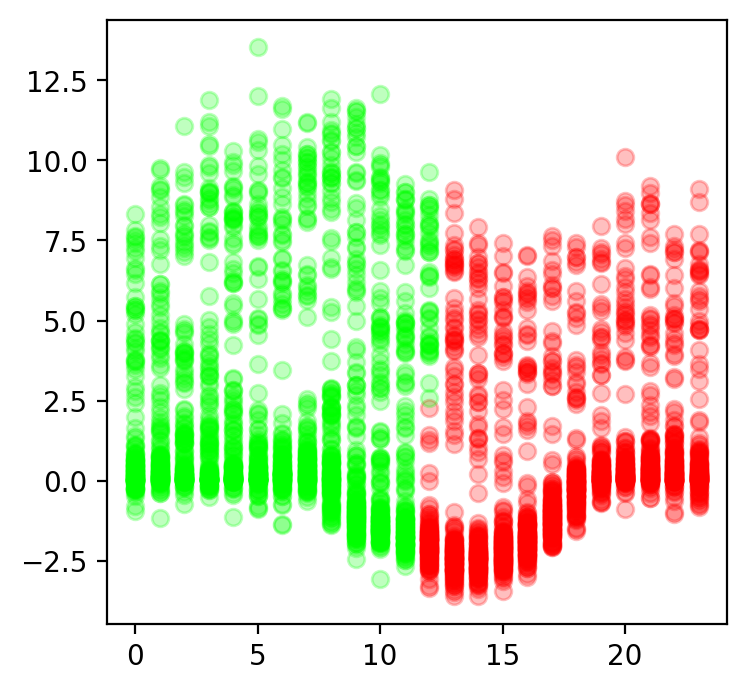

In [209]:
km = KMeans(n_clusters=2, init='random', n_init=10, max_iter=3000, tol=1e-04, random_state=120)

X = df[['hour', 'U', 'V']].dropna().to_numpy()
# X = X[3000:]
y_km = km.fit_predict(X)

fig, ax = plt.subplots(1,1 , figsize=(4,4), dpi=200)

for i in np.unique(y_km):
    mask = np.where(y_km == i)[0]
    ax.plot(X[mask,0], X[mask,1], 'o', color=colors[i])

# ax.set_xlim(-5,15)
# ax.set_ylim(-5,15)

In [133]:
hours_diff = 6
bins = np.arange(0,24.1, hours_diff, dtype=int)

for i, (left, right) in enumerate(zip(bins[:-1], bins[1:])):
    df.loc[((df.index.hour >= left) & (df.index.hour < right)),'type'] = i
    
df['type'] = df['type'].astype(int)

df['type'].nunique()

4

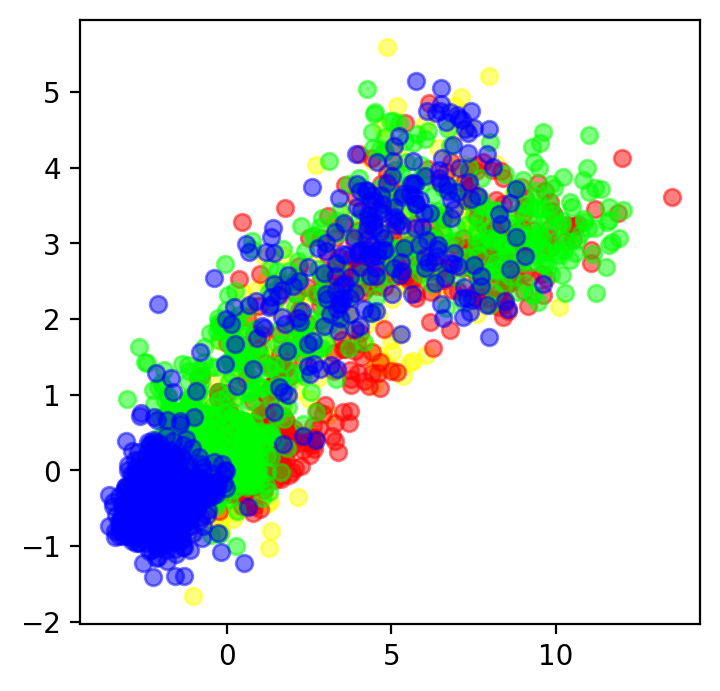

In [134]:
idx0 = np.where(y_km==0)[0]
idx1 = np.where(y_km==1)[0]



fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)
for i in df['type'].unique():
    mask = (df['type']==i)
    
    ax.plot(df[mask]['U'], df[mask]['V'], 'o', color=colors[i])




### Test for time-series convolution

In [9]:
t, v, clip_idx = convolve_timeseries(times, windspeeds, hours=3)
plt.plot(t, windspeeds[clip_idx:-clip_idx], t, v, 'o')

# This will be the std.dev to select wind speeds
sigma_wx = np.sqrt(sum((v - windspeeds[clip_idx:-clip_idx])**2))

NameError: name 'convolve_timeseries' is not defined

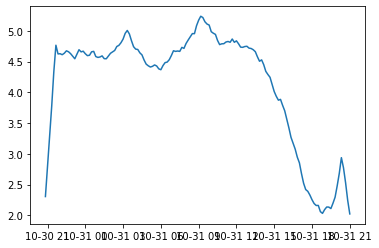

In [141]:
plt.plot(times, np.convolve(windspeeds, np.ones(10), mode='same')/sum(np.ones(10)))

## Compare perimeters

In [10]:
windspeeds = gdfMariaSim['windspeed'].unique()
winddirections = gdfMariaSim['winddirection'].unique()

wsidx = 10
wdidx = 15

windspeed = windspeeds[wsidx]
winddirection = winddirections[wdidx]

print(f'Calculating for ws={windspeed}, wd={winddirection}')

vertices_simulated = list(gdfMariaSim[(gdfMariaSim['windspeed'] == windspeed) &
                                      (gdfMariaSim['winddirection'] == winddirection) &
                                      (gdfMariaSim['compareidx'] == compareidx)].iloc[0]['geometry'][0].exterior.coords)
vertex_pairs = find_pairs(vertices_observed, vertices_simulated)
vertex_pairs_np = np.array(vertex_pairs)

vertices_A = vertex_pairs_np[:, :2]
vertices_B = vertex_pairs_np[:, 2:]

fig, ax = plt.subplots(1,1, figsize=(4,4), dpi=200)

ax.plot(vertices_A[0,0], vertices_A[0,1], 'co')
ax.plot(vertices_B[0,0], vertices_B[0,1], 'ro')

ax.plot(vertices_A[:,0], vertices_A[:,1], 'c')
ax.plot(vertices_B[:,0], vertices_B[:,1], 'r')

Calculating for ws=10.0, wd=90.0


/tmp/ipykernel_49/3259605093.py:12: ShapelyDeprecationWarning: __getitem__ for multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  vertices_simulated = list(gdfMariaSim[(gdfMariaSim['windspeed'] == windspeed) &


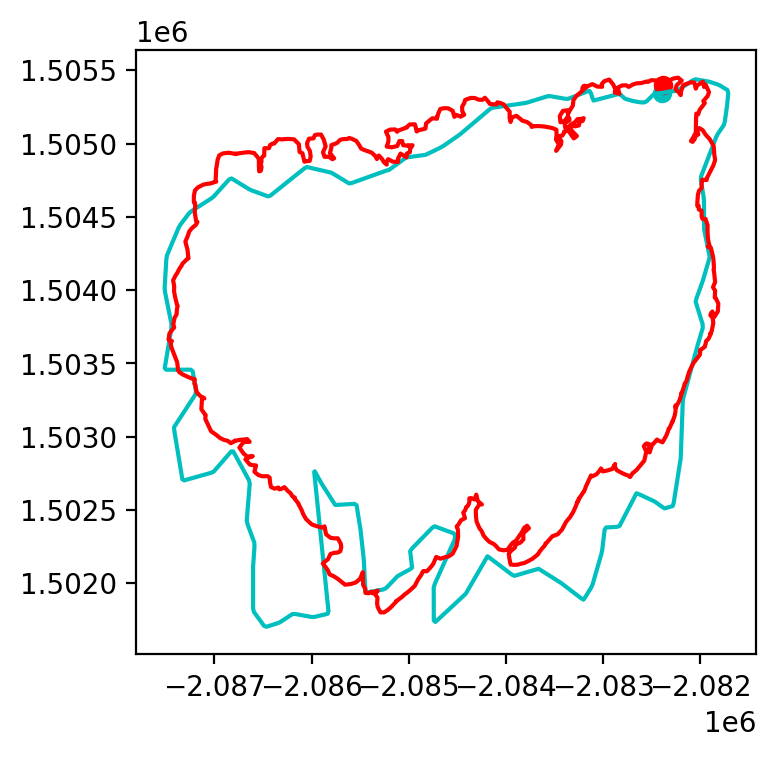